# Introduction & Overview

## Yes, the stock market

This notebook provides an analysis and approach to stock-market activities. Every day the market is open, the question to the would-be trader presents:
- Buy
- Sell
- Hold

This notebook explores several approaches to answering this *daily* question.

*daily*? Modern algorithmic trading asks not daily, but [many times per second](https://en.wikipedia.org/wiki/High-frequency_trading), whether to buy, sell, or hold. Being a lay practitioner without access to industrial trading tools, I approach this as a per-day question.

## The CRISP-DM Framework

The process is described according to the [CRISP-DM framework](https://www.datascience-pm.com/crisp-dm-2/), a standardized process for a data-mining project such as this one. All quotes that follow,
> which are indicated like this

are from the paper titled *CRISP-DM: Towards a Standard Process Model for Data Mining* by Wirth & Hipp, in the document "crisp-dm-overview.pdf" as downloaded [from this source](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip), and copied [locally here](./docs/crisp-dm-overview.pdf).

# Imports

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update(
    {
        "axes.grid": True,
        "figure.figsize": (16, 4),
    },
)

# Business Understanding

> This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary project plan designed to achieve the objectives.

The project objectives are to make stock trading recommendations on a daily basis, for a trading client. The project has been specified to concentrate only on equities trading, as opposed to any of the more complex financial instruments, such as options, shorts, bonds, etc...

The preliminary project plan is to obtain representative data from various publicly traded stocks, and then to choose a trading strategy, and to develop an algorithm to implement this strategy. Having obtained this data, multiple models will be developed, and compared to a benchmark of performance, here the S&P 500.

# Data Understanding

> The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.

Data sets have been obtained for 4 stocks (Apple, Amazon, Microsoft, and Tesla), covering 1 minute, 1 hour, and 1 day increments for a period of approximately 2 weeks. At this point in the project I have not decided yet which of these time increments to use. For comparison purposes, I also obtained a daily closing price for the S&P 500, a common benchmark used for stock-picking approaches.

# Data Preparation

> The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection, data cleaning, construction of new attributes, and transformation of data for modeling tools.

Load any data set as obtained from Yahoo finance, or Market Watch

In [3]:
def load_yahoo_csv(stock: str) -> pd.DataFrame:
    """
    Loads the stock-price data from a csv file obtained from yahoo finance
    Retains only the date, which is set as the index, and the closing price
    """
    filename = f"./data/{stock}.csv"
    df = pd.read_csv(filename)[["Date", "Close"]]
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df.rename(columns={"Close": stock}, inplace=True)
    return df

Load the Apple data

In [4]:
df = load_yahoo_csv(stock="AAPL")
df

,AAPL
Date,
2024-04-08,168.449997
2024-04-09,169.669998
2024-04-10,167.779999
2024-04-11,175.039993
2024-04-12,176.550003
...,...
2024-06-28,210.619995
2024-07-01,216.750000
2024-07-02,220.270004


Load the remaining stock data, and aggregate into a single dataframe

In [5]:
stocks = [
    "AMZN",
    "MSFT",
    "TSLA",
]

for stock in stocks:
    df_stock = load_yahoo_csv(stock=stock)
    assert all(
        df_stock.index == df.index
    ), f"Date index of {stock} does not match AAPL."
    df[stock] = df_stock[stock]

df

,AAPL,AMZN,MSFT,TSLA
Date,,,,
2024-04-08,168.449997,185.190002,424.589996,172.979996
2024-04-09,169.669998,185.669998,426.279999,176.880005
2024-04-10,167.779999,185.949997,423.260010,171.759995
2024-04-11,175.039993,189.050003,427.929993,174.600006
2024-04-12,176.550003,186.130005,421.899994,171.050003
...,...,...,...,...
2024-06-28,210.619995,193.250000,446.950012,197.880005
2024-07-01,216.750000,197.199997,456.730011,209.860001
2024-07-02,220.270004,200.000000,459.279999,231.259995


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2024-04-08 to 2024-07-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    62 non-null     float64
 1   AMZN    62 non-null     float64
 2   MSFT    62 non-null     float64
 3   TSLA    62 non-null     float64
dtypes: float64(4)
memory usage: 2.4 KB


Load the S&P 500 data, and perform similar basic cleanups on date and column renaming
- Also need to convert the string to a float after removing the comma

In [10]:
df_sp500 = load_yahoo_csv(stock="SPX")
df_sp500["SPX"] = df_sp500["SPX"].str.replace(",", "").apply(float)
df_sp500

,SPX
Date,
2024-07-05,5567.19
2024-07-03,5537.02
2024-07-02,5509.01
2024-07-01,5475.09
2024-06-28,5460.48
...,...
2024-04-12,5123.41
2024-04-11,5199.06
2024-04-10,5160.64


In [8]:
df["SPX"] = df_sp500["SPX"]
df

,AAPL,AMZN,MSFT,TSLA,SPX
Date,,,,,
2024-04-08,168.449997,185.190002,424.589996,172.979996,5202.39
2024-04-09,169.669998,185.669998,426.279999,176.880005,5209.91
2024-04-10,167.779999,185.949997,423.260010,171.759995,5160.64
2024-04-11,175.039993,189.050003,427.929993,174.600006,5199.06
2024-04-12,176.550003,186.130005,421.899994,171.050003,5123.41
...,...,...,...,...,...
2024-06-28,210.619995,193.250000,446.950012,197.880005,5460.48
2024-07-01,216.750000,197.199997,456.730011,209.860001,5475.09
2024-07-02,220.270004,200.000000,459.279999,231.259995,5509.01


Plot the daily closing price, normalized to each stock's closing price on the first day of the data set

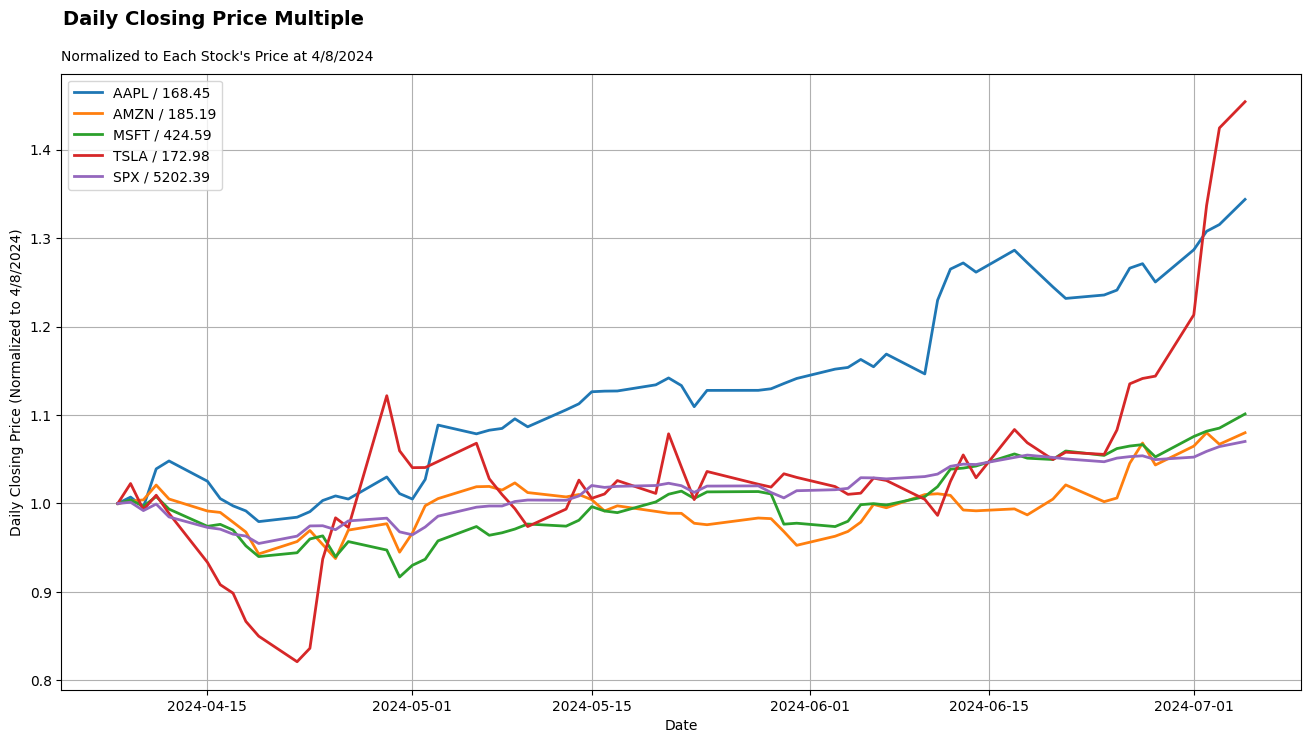

In [36]:
plt.figure(figsize=(16, 8))
for column in df.columns:
    reference = df[column][0]
    plt.plot(df[column] / reference, lw=2, label=f"{column} / {reference:.2f}")
plt.grid(True)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily Closing Price (Normalized to 4/8/2024)")
plt.title(
    "Normalized to Each Stock's Price at 4/8/2024",
    loc="left",
    fontsize=10,
    pad=10,
)
plt.suptitle(
    "Daily Closing Price Multiple",
    fontsize=14,
    fontweight="bold",
    x=0.126,
    y=0.96,
    ha="left",
)
plt.show()

# Modeling

> In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques require specific data formats.

# Evaluation

> At this stage in the project you have built one or more models that appear to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.

# Deployment

> Creation of the model is generally not the end of the project. Usually, the knowledge gained will need to be organized and presented in a way that the customer can use it. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining process. In many cases it will be the user, not the data analyst, who will carry out the deployment steps. In any case, it is important to understand up front what actions will need to be carried out in order to actually make use of the created models.